In [1]:
#python deep_dream.py path_to_your_base_image.jpg prefix_for_results
#python deep_dream.py img/mypic.jpg results/dream

from __future__ import print_function

from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import scipy
import argparse

from keras.applications import inception_v3
from keras import backend as K

/data/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [15]:
## load striped CAV, layer 9
import os
import cav
working_dir = '/home/tyler/Desktop/tcav_on_azure'
subpath = 'striped_sub_1-random500_0-mixed9'
cav_path = 'cavs/' + subpath + '-linear-0.1.pkl'
path = os.path.join(working_dir, cav_path)

this_cav = cav.CAV.load_cav(path)

In [20]:
layer_9_cav = this_cav.cavs[0]

In [86]:
base_image_path = '/home/tyler/Desktop/tcav_on_azure/concepts/horse_sub_1/img100.jpg'
result_prefix = '/home/tyler/Desktop/tcav_on_azure/results/test'

settings = {
    'features': {
        'mixed9': 10
    },
}


def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = load_img(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

K.set_learning_phase(0)

# Build the InceptionV3 network with our placeholder.
# The model will be loaded with pre-trained ImageNet weights.
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)
dream = model.input
print('Model loaded.')

# Get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Define the loss.

loss = K.variable(0.)
for layer_name in settings['features']:
    # Add the L2 norm of the features of a layer to the loss.
    assert layer_name in layer_dict.keys(), 'Layer ' + layer_name + ' not found in model.'
    coeff = settings['features'][layer_name]
    x = layer_dict[layer_name].output
    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(x), 'float32'))
    if K.image_data_format() == 'channels_first':
        loss += coeff * K.sum(K.square(x[:, :, 2: -2, 2: -2])) / scaling
    else:
        loss += coeff * K.sum(K.square(x[:, 2: -2, 2: -2, :])) / scaling
    #my_loss = loss

#loss = K.variable(0.)


# Compute the gradients of the dream wrt the loss.
grads = K.gradients(loss, dream)[0]
# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())

# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)


def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values


def resize_img(img, size):
    img = np.copy(img)
    if K.image_data_format() == 'channels_first':
        factors = (1, 1,
                   float(size[0]) / img.shape[2],
                   float(size[1]) / img.shape[3])
    else:
        factors = (1,
                   float(size[0]) / img.shape[1],
                   float(size[1]) / img.shape[2],
                   1)
    return scipy.ndimage.zoom(img, factors, order=1)


def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('..Loss value at', i, ':', loss_value)
        #print(loss.eval())
        x += step * grad_values
    return x


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)


"""Process:
- Load the original image.
- Define a number of processing scales (i.e. image shapes),
    from smallest to largest.
- Resize the original image to the smallest scale.
- For every scale, starting with the smallest (i.e. current one):
    - Run gradient ascent
    - Upscale image to the next scale
    - Reinject the detail that was lost at upscaling time
- Stop when we are back to the original size.
To obtain the detail lost during upscaling, we simply
take the original image, shrink it down, upscale it,
and compare the result to the (resized) original image.
"""


# Playing with these hyperparameters will also allow you to achieve new effects
step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale
max_loss = 10

Model loaded.


In [87]:
img = preprocess_image(base_image_path)
if K.image_data_format() == 'channels_first':
    original_shape = img.shape[2:]
else:
    original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)

save_img(img, fname=result_prefix + '.png')

Processing image shape (244, 217)
..Loss value at 0 : 0.04850215


ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`

In [84]:
from keras.preprocessing import image
img_path = '/home/tyler/Desktop/tcav_on_azure/results/test.png'
img = image.load_img(img_path, target_size=(299, 299))

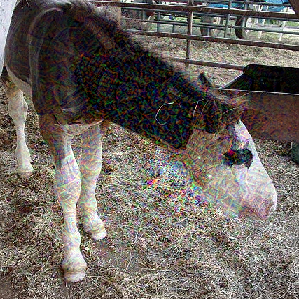

In [85]:
img

In [42]:
my_loss.shape

TensorShape([])

In [30]:
x.shape

TensorShape([Dimension(None), Dimension(None), Dimension(None), Dimension(1280)])

In [36]:
settings['features']

{'mixed8': 5}

In [47]:
#fetch_loss_and_grads = K.function([dream], outputs)


In [50]:
#outs = fetch_loss_and_grads([x])
grads = K.gradients(loss, dream)[0]


In [80]:
loss

<tf.Tensor 'add_7:0' shape=() dtype=float32>

In [60]:
loss = K.variable(0.)
for layer_name in settings['features']:
    # Add the L2 norm of the features of a layer to the loss.
    assert layer_name in layer_dict.keys(), 'Layer ' + layer_name + ' not found in model.'
    coeff = settings['features'][layer_name]
    x = layer_dict[layer_name].output
    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(x), 'float32'))
    if K.image_data_format() == 'channels_first':
        loss += coeff * K.sum(K.square(x[:, :, 2: -2, 2: -2])) / scaling
    else:
        loss += coeff * K.sum(K.square(x[:, 2: -2, 2: -2, :])) / scaling

In [71]:
loss

<tf.Tensor 'add_7:0' shape=() dtype=float32>

In [72]:
K.sum(K.square(x[:, :, 2: -2, 2: -2]))

<tf.Tensor 'Sum_9:0' shape=() dtype=float32>

In [73]:
K.square(x[:, :, 2: -2, 2: -2])

<tf.Tensor 'Square_13:0' shape=(?, ?, ?, 2044) dtype=float32>

In [74]:
x[:, :, 2: -2, 2: -2]

<tf.Tensor 'strided_slice_14:0' shape=(?, ?, ?, 2044) dtype=float32>

In [81]:
sess = K.get_session()

loss.eval(session=sess)

InvalidArgumentError: You must feed a value for placeholder tensor 'input_5' with dtype float and shape [?,?,?,3]
	 [[node input_5 (defined at /data/anaconda/envs/py35/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:517) ]]

Caused by op 'input_5', defined at:
  File "/data/anaconda/envs/py35/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/data/anaconda/envs/py35/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/data/anaconda/envs/py35/lib/python3.5/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/data/anaconda/envs/py35/lib/python3.5/asyncio/base_events.py", line 1425, in _run_once
    handle._run()
  File "/data/anaconda/envs/py35/lib/python3.5/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-37-d980eeee20c6>", line 52, in <module>
    include_top=False)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/keras/applications/__init__.py", line 28, in wrapper
    return base_fun(*args, **kwargs)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/keras/applications/inception_v3.py", line 11, in InceptionV3
    return inception_v3.InceptionV3(*args, **kwargs)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/keras_applications/inception_v3.py", line 157, in InceptionV3
    img_input = layers.Input(shape=input_shape)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/keras/engine/input_layer.py", line 178, in Input
    input_tensor=tensor)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/keras/engine/input_layer.py", line 87, in __init__
    name=self.name)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 517, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 2077, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 5791, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'input_5' with dtype float and shape [?,?,?,3]
	 [[node input_5 (defined at /data/anaconda/envs/py35/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:517) ]]
